In [5]:
from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.utils import laplacian_matrix
from src.torch_erg.samplers import GWGSampler, MHSampler
import torch
import numpy as np
import networkx as nx
import random as rnd

from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix
# parsing the .m file into a suitable format, and perform some sanity checks
import matplotlib.pyplot as plt

from plots import *
from graph_generators import *
from param_estimation import *
from other_g_stats import *

In [6]:
name = '30_ieee'
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

In [7]:
alpha = 0.001
niter = 300000
min_change = 0.01
update_steps = 3

niter_sampling = 200000

In [8]:
class MySamplerNoAC(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)
    def observables(self,mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        avg_degree = torch.sum(mtx, dim=1).mean()
        avg_clustering = avg_clustering_coeff(mtx)

        return(torch.stack([edges, triangles, avg_degree, avg_clustering]))
    
betas = torch.tensor([0., 0., 0., 0.], dtype=float)
sampler_no_ac = MySamplerNoAC(backend="cuda")
obs_no_ac = sampler_no_ac.observables(ordmat)
params_no_ac, graphs_no_ac = sampler_no_ac.param_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=betas,
                      niter=niter,
                      params_update_every=update_steps,
                      save_every=50,
                      save_params=True,
                      alpha=alpha,                      
                      min_change=min_change)

CUDA backend not available falling back to cpu


100%|██████████| 300000/300000 [08:05<00:00, 617.91it/s]

number of accepted steps is:  227596
number of rejected samples:  72404
number of effective updates is:  75865


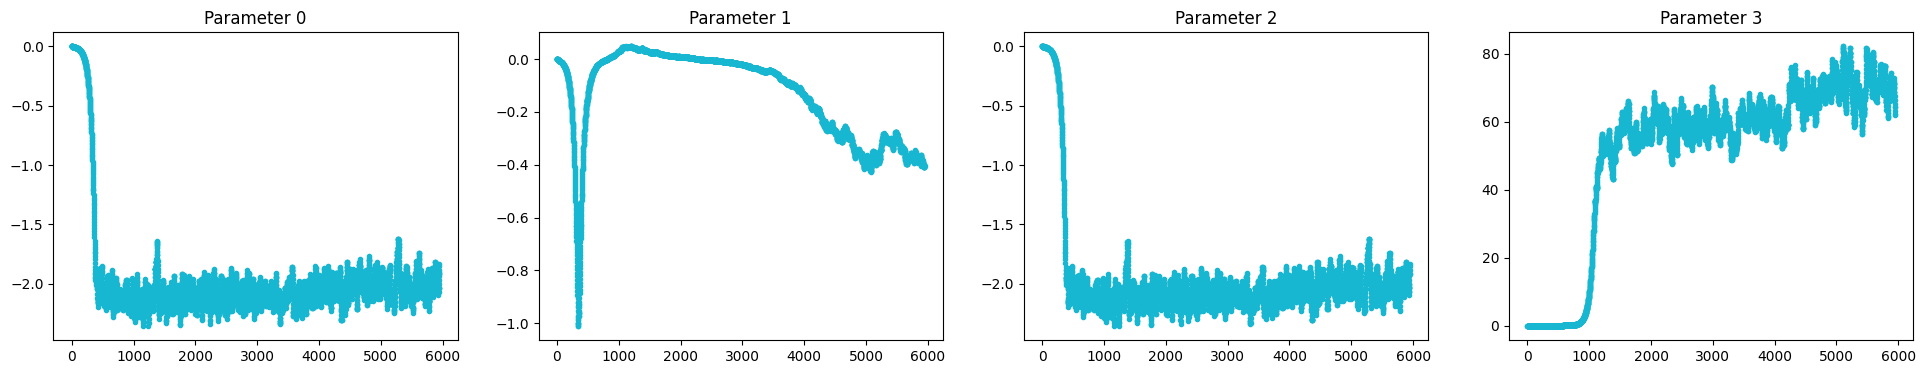

In [9]:
plot_params_iterations(params_no_ac)

In [10]:
params_estimate = torch.stack(params_no_ac[-1000:]).mean(axis = 0)
params_estimate

tensor([-2.0018, -0.3545, -2.0018, 70.5209], dtype=torch.float64)

In [11]:

algebraic_conn = torch.tensor([0])

new_params = torch.cat((params_estimate, algebraic_conn), dim=0)
new_params

tensor([-2.0018, -0.3545, -2.0018, 70.5209,  0.0000], dtype=torch.float64)

In [12]:
observables_no_ac, graphs_no_ac = sampler_no_ac.sample_run(graph=ordmat,
                      observables=obs_no_ac,
                      params=params_estimate,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 200000/200000 [48:18<00:00, 69.00it/s]    


number of accepted steps is:  95001
number of rejected samples:  104999
Mean obs:  tensor([25.3089,  3.8069,  1.6873,  0.3227], dtype=torch.float64)


In [13]:
connected_graphs_no_ac, connected_observables_no_ac = connected_graphs(sampler_no_ac, graphs_no_ac, max_components=1)

print(f"Fraction of connected graphs (no ac): {len(connected_graphs_no_ac)} over {len(graphs_no_ac)} sampled")

Fraction of connected graphs (no ac): 224 over 4102 sampled


In [14]:
class GWGSampler(GWGSampler):
    def __init__(self, backend: str):
        super().__init__(backend)

    def observables(self,mtx):
        
        L = laplacian_matrix(mtx)
        a3 = torch.matmul(torch.matmul(mtx,mtx),mtx)

        edges = torch.sum(mtx)/2
        triangles = torch.trace(a3)/6
        ac = torch.linalg.eigvalsh(L)[1]
        deg = torch.diagonal(L)
        tri_diag = torch.diagonal(a3) / 2

        valid = deg > 1
        local_clust = torch.zeros_like(deg)
        local_clust[valid] = tri_diag[valid] / (deg[valid] * (deg[valid] - 1))
        avg_clustering = torch.mean(local_clust[valid])

        avg_degree = torch.sum(mtx, dim=1).mean()

        return(torch.stack([edges, triangles, avg_degree, avg_clustering, ac]))

ac_sampler = GWGSampler(backend="cuda")


CUDA backend not available falling back to cpu


In [15]:
obs_with_ac = ac_sampler.observables(ordmat)
obs_with_ac

tensor([41.0000,  6.0000,  2.7333,  0.1304,  0.2121], dtype=torch.float64)

In [16]:
mod_params = new_params + torch.tensor([0., 0., 0., 0., 10.])

In [17]:
params_estimate, mod_params

(tensor([-2.0018, -0.3545, -2.0018, 70.5209], dtype=torch.float64),
 tensor([-2.0018, -0.3545, -2.0018, 70.5209, 10.0000], dtype=torch.float64))

In [18]:
observables_ac, graphs_ac = ac_sampler.sample_run(graph=ordmat,
                      observables=obs_with_ac,
                      params=mod_params,
                      niter=niter_sampling,
                      save_every=50)

100%|██████████| 200000/200000 [05:04<00:00, 655.91it/s]

number of accepted steps is:  74357
number of rejected samples:  125643
Mean obs:  tensor([52.4242,  8.3759,  3.4949,  0.1071,  0.4949], dtype=torch.float64)


In [19]:
connected_graphs_ac, connected_observables_ac = connected_graphs(ac_sampler, graphs_ac, max_components=1)

print(f"Fraction of connected graphs: {len(connected_graphs_ac)} over {len(graphs_ac)} sampled")

Fraction of connected graphs: 3373 over 4041 sampled


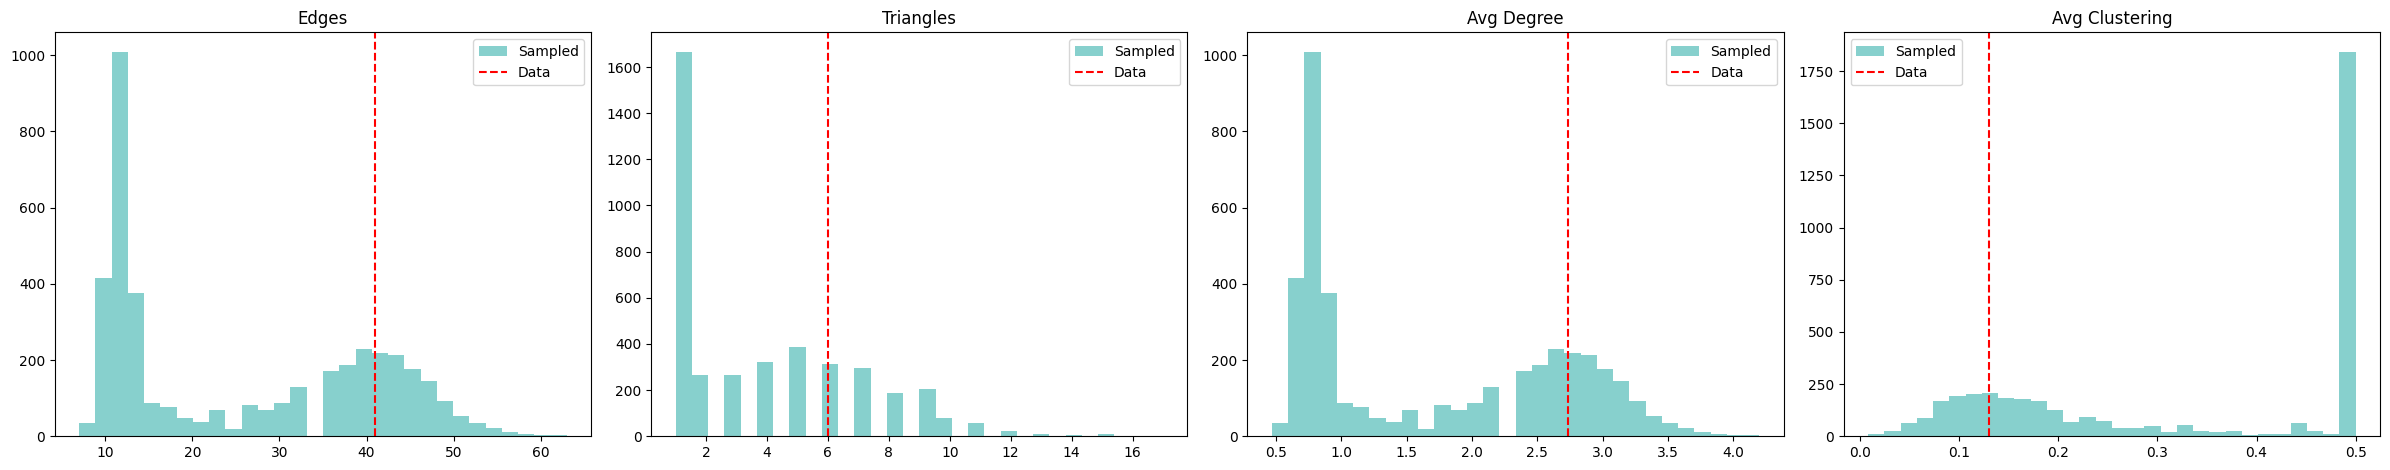

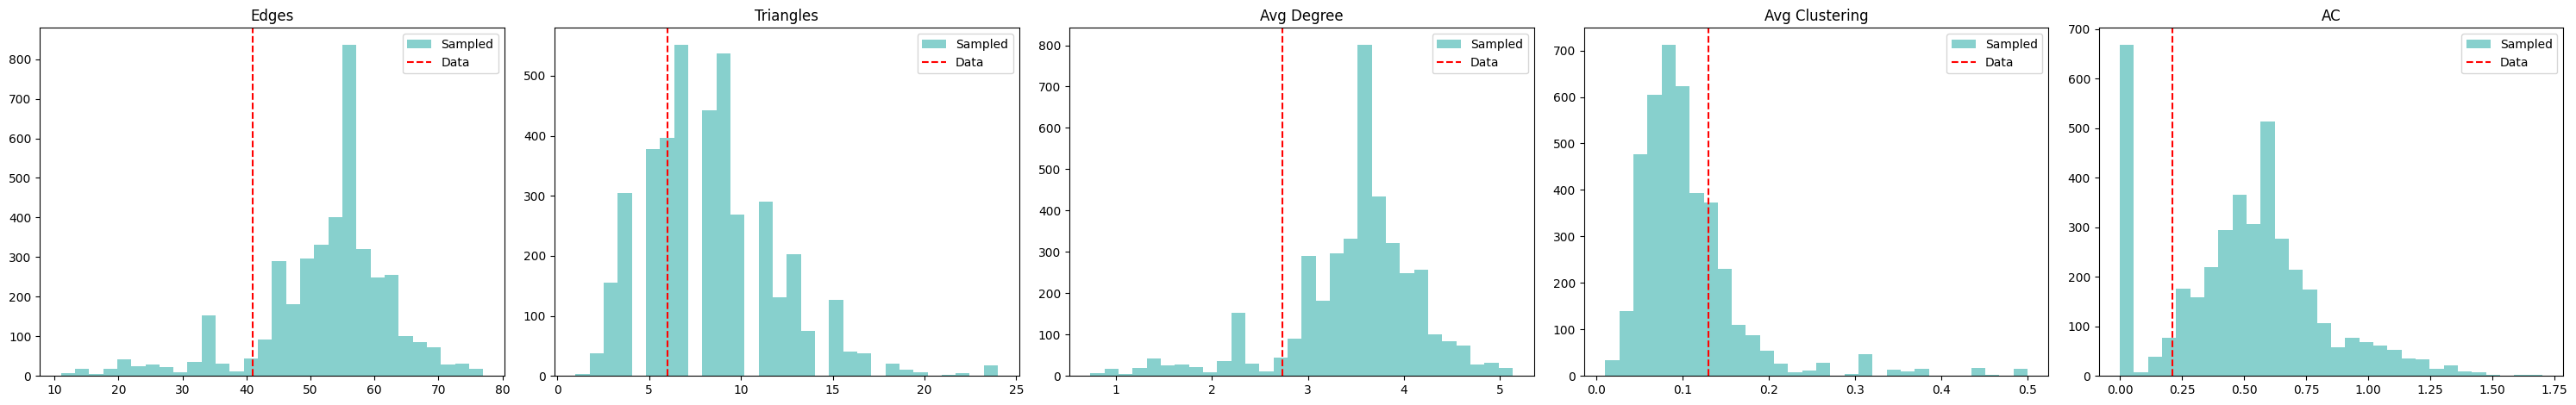

In [20]:
hist_obs_samples(observables_no_ac, obs_no_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering'])
hist_obs_samples(observables_ac, obs_with_ac, obs_labels = ['Edges', 'Triangles', 'Avg Degree', 'Avg Clustering', 'AC'])

In [21]:
mods = [0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

observable_runs = []
graph_runs = []
number_of_connected = []
number_of_sampled = []

for i in range(len(mods)):
    mod_params = new_params + torch.tensor([0., 0., 0., 0., mods[i]])
    observables_ac, graphs_ac = ac_sampler.sample_run(graph=ordmat,
                          observables=obs_with_ac,
                          params=mod_params,
                          niter=niter_sampling,
                          save_every=50)
                          
    connected_graphs_ac, connected_observables_ac = connected_graphs(ac_sampler, graphs_ac, max_components=1)
    observable_runs.append(observables_ac)
    graph_runs.append(graphs_ac)
    number_of_connected.append(len(connected_graphs_ac))
    number_of_sampled.append(len(graphs_ac))

    print(f"Mod: {mods[i]} - Fraction of connected graphs: {len(connected_graphs_ac)} over {len(graphs_ac)} sampled")

100%|██████████| 200000/200000 [05:18<00:00, 627.18it/s]


number of accepted steps is:  125043
number of rejected samples:  74957
Mean obs:  tensor([3.6659e+01, 5.9066e+00, 2.4439e+00, 1.8734e-01, 3.2387e-02],
       dtype=torch.float64)
Mod: 0 - Fraction of connected graphs: 471 over 3984 sampled


100%|██████████| 200000/200000 [05:04<00:00, 657.86it/s]


number of accepted steps is:  102844
number of rejected samples:  97156
Mean obs:  tensor([2.8979e+01, 4.5473e+00, 1.9320e+00, 2.7897e-01, 2.1099e-02],
       dtype=torch.float64)
Mod: 0.0001 - Fraction of connected graphs: 281 over 3870 sampled


100%|██████████| 200000/200000 [05:02<00:00, 660.10it/s]


number of accepted steps is:  97301
number of rejected samples:  102699
Mean obs:  tensor([2.6105e+01, 3.9456e+00, 1.7403e+00, 3.1251e-01, 1.6115e-02],
       dtype=torch.float64)
Mod: 0.001 - Fraction of connected graphs: 222 over 4024 sampled


100%|██████████| 200000/200000 [05:21<00:00, 622.20it/s]


number of accepted steps is:  122956
number of rejected samples:  77044
Mean obs:  tensor([3.5539e+01, 5.7032e+00, 2.3692e+00, 2.0000e-01, 2.7842e-02],
       dtype=torch.float64)
Mod: 0.01 - Fraction of connected graphs: 400 over 3999 sampled


100%|██████████| 200000/200000 [05:12<00:00, 639.30it/s]


number of accepted steps is:  112415
number of rejected samples:  87585
Mean obs:  tensor([3.2037e+01, 5.1344e+00, 2.1358e+00, 2.4403e-01, 2.5993e-02],
       dtype=torch.float64)
Mod: 0.1 - Fraction of connected graphs: 362 over 4033 sampled


100%|██████████| 200000/200000 [05:28<00:00, 608.05it/s]


number of accepted steps is:  129275
number of rejected samples:  70725
Mean obs:  tensor([37.8017,  6.0383,  2.5201,  0.1740,  0.0390], dtype=torch.float64)
Mod: 1 - Fraction of connected graphs: 548 over 4095 sampled


100%|██████████| 200000/200000 [05:10<00:00, 644.35it/s]


number of accepted steps is:  78034
number of rejected samples:  121966
Mean obs:  tensor([52.8446,  8.5225,  3.5230,  0.1060,  0.5176], dtype=torch.float64)
Mod: 10 - Fraction of connected graphs: 3369 over 3937 sampled


100%|██████████| 200000/200000 [04:36<00:00, 722.44it/s]


number of accepted steps is:  11
number of rejected samples:  199989
Mean obs:  tensor([41.0025,  6.0005,  2.7335,  0.1304,  0.2122], dtype=torch.float64)
Mod: 100 - Fraction of connected graphs: 2004 over 2004 sampled


In [50]:
mods, number_of_connected, number_of_sampled

([0, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 [471, 281, 222, 400, 362, 548, 3369, 2004],
 [3984, 3870, 4024, 3999, 4033, 4095, 3937, 2004])

Text(0, 0.5, 'Number of Graphs')

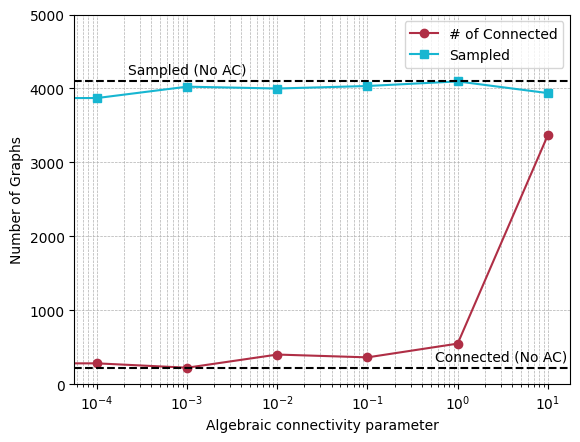

In [52]:
plt.plot(mods[:-1], number_of_connected[:-1], marker="o", label="# of Connected", color='#af2e45')
plt.plot(mods[:-1], number_of_sampled[:-1], marker="s", label="Sampled", color='#17B6D1')
plt.ylim(0, 5000)
plt.axhline(y=len(connected_graphs_no_ac), color='black', linestyle='--')
plt.axhline(y=len(graphs_no_ac), color='black', linestyle='--')
plt.text(
    x=10e-4, y=len(graphs_no_ac)+50,
    s="Sampled (No AC)", color="black",
    ha="center", va="bottom"
)
plt.text(
    x=3, y=len(connected_graphs_no_ac)+50,
    s="Connected (No AC)", color="black",
    ha="center", va="bottom"
)
plt.legend()

plt.xscale("log")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.xlabel("Algebraic connectivity parameter")
plt.ylabel("Number of Graphs")